In [1]:
!pip install tensorflow-gpu tensorflow gym keras-rl2 --upgrade mplfinance

In [2]:
import pandas as pd
import numpy as np
from gym import Env
from gym.spaces import Discrete, Box
import random
import mplfinance as mpf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy, BoltzmannGumbelQPolicy
from rl.memory import SequentialMemory

In [38]:
class MyEnv():
    data_ticker = ""
    data = None
    test_data = None
    state = None
    test_state = None
    state_id = 0
    min_state_id = 0
    max_state_id = 0
    test_state_id = 0
    test_min_state_id = 0
    test_max_state_id = 0
    total_reward = 0
    done = False
    test_done = False
    positive_reward = 1
    negative_reward = -1
    episode_size = 5000
    num_episode = 1
    lookback_window_size=600
    max_time_trade = 15
    action_space = np.arange(-15, 16)
    #action_space = np.arange(0, 32)
    history_trades = pd.DataFrame()
    path_data = {
        "AUDCAD":"data/AUDCAD.csv",
        "AUDCHF":"",
        "AUDNZD":"",
        "AUDUSD":"",
    }
    path_test_data = {
        "AUDCAD":"data/AUDCAD_test1.csv",
        "AUDCHF":"",
        "AUDNZD":"",
        "AUDUSD":"",
    }
    
    def __init__(self, data_ticker="AUDCAD", lookback_window_size=600, episode_size=5000):
        self.data_ticker = data_ticker
        self.episode_size = episode_size
        self.lookback_window_size = lookback_window_size
        self.data = pd.read_csv(self.path_data[data_ticker])
        self.test_data = pd.read_csv(self.path_test_data[data_ticker])
        #self.data["Date"] = pd.to_datetime(self.data["Date"] + " " + self.data["Time"])
        #self.data.pop("Time")
        self.max_state_id = (len(self.data.index) - 2) - self.episode_size - self.max_time_trade
        self.min_state_id = self.lookback_window_size - 1
        self.test_max_state_id = (len(self.test_data.index) - 2) - self.max_time_trade
        self.test_min_state_id = self.lookback_window_size - 1
        
    def state_return(self, test=False):
        if(test == True):
            dfr = self.test_state
        else:
            dfr = self.state
        dfr = dfr.drop(["Ticker", "Date"], axis=1)
        return dfr.values
    
    def reset(self):
        self.done = False
        self.num_episode = 1
        self.state_id = random.randint(self.min_state_id, self.max_state_id)
        #print("reset")
        self.state = self.data[self.state_id - self.lookback_window_size + 1:self.state_id +  1]
        return self.state_return()
    
    def test_reset(self):
        self.test_done = False
        self.total_reward = 0
        self.history_trades = pd.DataFrame()
        self.test_state_id = self.test_min_state_id
        self.test_state = self.test_data[self.test_state_id - self.lookback_window_size + 1:self.test_state_id +  1]
        return self.state_return(test=True)
        
    def step(self, action):
        info = {}
        action -= 15 
        if(action == 0):
            reward = 0
            #print("0")
        elif(action < 0 and action >= -15):
            time_trade = abs(action)
            if(self.data.loc[self.state_id, 'Close'] < self.data.loc[self.state_id + time_trade, 'Close']):
                reward = self.positive_reward
            else:
                reward = self.negative_reward
            #print("-")
        elif(action > 0 and action <= 15):
            time_trade = abs(action)
            if(self.data.loc[self.state_id, 'Close'] > self.data.loc[self.state_id + time_trade, 'Close']):
                reward = self.positive_reward
            else:
                reward = self.negative_reward
            #print("+")
        else:
            reward = self.negative_reward * 20
        if(self.done == False):
            self.state_id += 1
            self.num_episode += 1
        self.state = self.data[self.state_id - self.lookback_window_size + 1:self.state_id + 1]
        if(self.num_episode > self.episode_size):
            self.done = True
        #print("step")
        return self.state_return(), reward, self.done, info
    
    
    def render(self, render_type = "line", render_volume = True, render_scale = 1):
        if(self.state != None):
            render_data = self.state.copy()
            render_data.set_index('Date', inplace=True)
            mpf.plot(data=render_data, type=render_type, volume=render_volume, figscale=render_scale, style="yahoo", axtitle=self.data_ticker)
            #print("render")
        else:
            print("Не вызвано событие reset")
            
    
    def test_step(self, action):
        info = {}
        if(action == 0):
            self.total_reward += 0
            #print("0")
        elif(action < 0):
            time_trade = abs(action)
            if(self.test_data.loc[self.state_id, 'Close'] < self.test_data.loc[self.state_id + time_trade, 'Close']):
                self.total_reward += self.positive_reward
            else:
                self.total_reward += self.negative_reward
            #print("-")
        elif(action > 0):
            time_trade = abs(action)
            if(self.test_data.loc[self.state_id, 'Close'] > self.test_data.loc[self.state_id + time_trade, 'Close']):
                self.total_reward += self.positive_reward
            else:
                self.total_reward += self.negative_reward
            #print("+")
        self.history_trades = self.history_trades.append({"Date": self.test_data.loc[self.test_state_id, 'Date'], "Reward": self.total_reward}, ignore_index=True)
        if(self.test_done == False):
            self.test_state_id += 1
        self.test_state = self.test_data[self.test_state_id - self.lookback_window_size + 1:self.test_state_id + 1]
        if(self.test_max_state_id == self.test_state_id):
            self.test_done = True
        #print("step")
        return self.state_return(test=True), self.total_reward, self.test_done, info
    
    def render_test_reward(self, render_type = "line", render_scale = 1):
        if(self.history_trades.empty != True):
            render_data = self.history_trades.copy()
            #render_data["Date"] = pd.to_datetime(render_data["Date"]).dt.date
            render_data.set_index('Date', inplace=True)
            render_data.plot(figsize=(20,6))
            plt.show()
            #render_data["Date"] = pd.to_datetime(render_data["Date"])
            #render_data["Date"] = render_data["Date"].dt.strftime('%Y.%m.%d')
            #render_data.plot("Date", "Reward")
            #plt.figure(figsize=(24,10), dpi= 80)
            #plt.plot('Date', 'Reward', data=render_data, color='tab:red')
            
            # Decoration
            #plt.ylim(50, 750)
            #xtick_location = render_data.index.tolist()[::20]
            #xtick_labels = [x[-4:] for x in render_data.Date.tolist()[::20]]
            #plt.xticks(ticks=xtick_location, labels=xtick_labels, rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
            #plt.yticks(fontsize=12, alpha=.7)
            #plt.title(self.data_ticker, fontsize=22)
            #plt.grid(axis='both', alpha=.3)

            # Remove borders
            #plt.gca().spines["top"].set_alpha(0.0)    
            #plt.gca().spines["bottom"].set_alpha(0.3)
            #plt.gca().spines["right"].set_alpha(0.0)    
            #plt.gca().spines["left"].set_alpha(0.3) 
            
            #plt.show()
            #print("render")
        else:
            print("Не вызвано событие test_reset")
        

In [42]:
def build_model(states, actions, size_hidden_layers = 128):
    model = Sequential()
    model.add(Flatten(input_shape=(1, int(states/5), 5)))
    model.add(Dense(size_hidden_layers, activation='relu'))
    model.add(Dense(size_hidden_layers, activation="relu"))
    model.add(Dense(actions, activation="linear"))
    return model

In [5]:
def  build_dqn_agent(model, actions):
    policy = BoltzmannGumbelQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

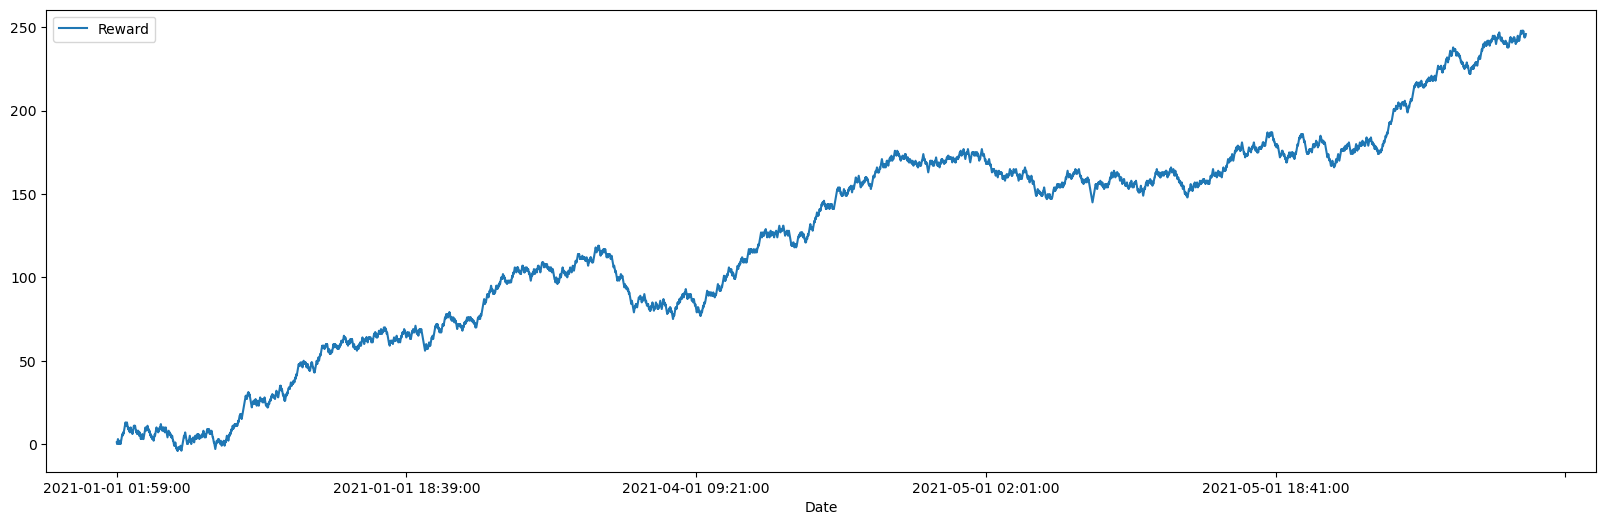

In [80]:
test_env = MyEnv(lookback_window_size=120, episode_size=1000)
state = test_env.test_reset()
done = False
score = 0 
while not done:
        action = random.randint(-15, 16)
        n_state, reward, done, info = test_env.test_step(action)
        score+=reward
        #print('Score:{0}'.format(score))
test_env.render_test_reward()
    
    
    

In [81]:
test_env.history_trades.duplicated(keep=False)

0       False
1       False
2       False
3       False
4       False
        ...  
4860    False
4861    False
4862    False
4863    False
4864    False
Length: 4865, dtype: bool

In [6]:
audcad_env = MyEnv(lookback_window_size=120, episode_size=1000)
audcad_env.data

,Ticker,Date,Open,High,Low,Close,Volume
0,AUDCAD,2015-01-01 00:00:00,0.94819,0.94893,0.94739,0.94848,910
1,AUDCAD,2015-01-01 00:01:00,0.94848,0.94852,0.94805,0.94842,423
2,AUDCAD,2015-01-01 00:02:00,0.94842,0.94846,0.94809,0.94844,253
3,AUDCAD,2015-01-01 00:03:00,0.94751,0.94846,0.94751,0.94838,476
4,AUDCAD,2015-01-01 00:04:00,0.94838,0.94856,0.94798,0.94842,658
...,...,...,...,...,...,...,...
2203350,AUDCAD,2020-12-31 23:56:00,0.98124,0.98143,0.98091,0.98127,499
2203351,AUDCAD,2020-12-31 23:57:00,0.98129,0.98140,0.98084,0.98111,886
2203352,AUDCAD,2020-12-31 23:58:00,0.98111,0.98157,0.98082,0.98130,946
2203353,AUDCAD,2020-12-31 23:59:00,0.98132,0.98139,0.98036,0.98071,1642


In [83]:
episodes = 10
for episode in range(1, episodes+1):
    state = audcad_env.reset()
    done = False
    score = 0 
    
    while not done:
        #audcad_env.render()
        action = random.randint(-15, 15)
        n_state, reward, done, info = audcad_env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))

Episode:1 Score:6
Episode:2 Score:-14
Episode:3 Score:7
Episode:4 Score:23
Episode:5 Score:-81
Episode:6 Score:17
Episode:7 Score:-4
Episode:8 Score:-21
Episode:9 Score:-22
Episode:10 Score:-57


In [7]:
#audcad_env.action_space
#audcad_env.state
st = audcad_env.reset()
#st
#st.drop("Date", axis=1)
#len(audcad_env.action_space)

In [8]:
model = build_model(audcad_env.lookback_window_size * 5, len(audcad_env.action_space))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 600)               0         
                                                                 
 dense (Dense)               (None, 128)               76928     
                                                                 
 dense_1 (Dense)             (None, 31)                3999      
                                                                 
Total params: 80,927
Trainable params: 80,927
Non-trainable params: 0
_________________________________________________________________


In [9]:
dqn = build_dqn_agent(model, len(audcad_env.action_space))
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])
dqn.fit(audcad_env, nb_steps=10000, visualize=False, verbose=1, log_interval= 1000)

Training for 10000 steps ...
Interval 1 (0 steps performed)
   1/1000 [..............................] - ETA: 1:07 - reward: -1.0000

/home/roman/anaconda3/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/home/roman/anaconda3/lib/python3.8/site-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


1000/1000 [==============================] - 11s 11ms/step - reward: 0.0740
1 episodes - episode_reward: 74.000 [74.000, 74.000] - loss: 1839.024 - mae: 356.357 - mean_q: 743.457

Interval 2 (1000 steps performed)
1000/1000 [==============================] - 11s 11ms/step - reward: -0.0160
1 episodes - episode_reward: -16.000 [-16.000, -16.000] - loss: 854.391 - mae: 441.514 - mean_q: 894.108

Interval 3 (2000 steps performed)
1000/1000 [==============================] - 13s 13ms/step - reward: 0.0100
1 episodes - episode_reward: 10.000 [10.000, 10.000] - loss: 469.456 - mae: 410.792 - mean_q: 802.813

Interval 4 (3000 steps performed)
1000/1000 [==============================] - 16s 16ms/step - reward: -0.1400
1 episodes - episode_reward: -140.000 [-140.000, -140.000] - loss: 524.347 - mae: 408.342 - mean_q: 779.215

Interval 5 (4000 steps performed)
1000/1000 [==============================] - 12s 12ms/step - reward: -0.0180
1 episodes - episode_reward: -18.000 [-18.000, -18.000] - l

In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12216668619311299832
xla_global_id: -1
]


In [39]:
audcad_env = MyEnv(lookback_window_size=120, episode_size=5000)
n_state = audcad_env.reset()

model = build_model(audcad_env.lookback_window_size * 5, len(audcad_env.action_space), size_hidden_layers = 1024)
dqn = build_dqn_agent(model, len(audcad_env.action_space))
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])

num_steps = 0
while True:
    dqn.fit(audcad_env, nb_steps=100000, visualize=False, verbose=1, log_interval= 5000)
    num_steps += 100000
    dqn.save_weights("weights/audcad_weights_" + str(num_steps) + ".h5f")

#done = False
#score = 0
#n_state = audcad_env.reset()

#while not done:
        #audcad_env.render()
        #action = dqn.forward(n_state)
        #n_state, reward, done, info = audcad_env.step(action)
        #score+=reward
        #print('Score:{}, Action:{}'.format(score, action))    

Training for 50000 steps ...
Interval 1 (0 steps performed)
1000/1000 [==============================] - 17s 16ms/step - reward: 0.0140
1 episodes - episode_reward: 14.000 [14.000, 14.000] - loss: 1687.624 - mae: 288.789 - mean_q: 756.350

Interval 2 (1000 steps performed)
1000/1000 [==============================] - 14s 14ms/step - reward: 0.0280
1 episodes - episode_reward: 28.000 [28.000, 28.000] - loss: 986.705 - mae: 386.934 - mean_q: 888.598

Interval 3 (2000 steps performed)
1000/1000 [==============================] - 14s 14ms/step - reward: -0.0040
1 episodes - episode_reward: -4.000 [-4.000, -4.000] - loss: 613.228 - mae: 381.364 - mean_q: 841.965

Interval 4 (3000 steps performed)
1000/1000 [==============================] - 14s 14ms/step - reward: 0.0200
1 episodes - episode_reward: 20.000 [20.000, 20.000] - loss: 668.833 - mae: 374.347 - mean_q: 827.912

Interval 5 (4000 steps performed)
1000/1000 [==============================] - 14s 14ms/step - reward: -0.0460
1 episode

In [23]:
n_state.shape
#result = dqn.model(n_state, training=False)
#result

(120, 5)